# <a id='toc1_'></a>[Efficiency Analysis](#toc0_)
This notebook demonstrates the use of `EfficiencyAnalysis` class in `src/analysis/vram_usage.py` for analyzing the efficiency of jobs, users, and PI groups.

**Table of contents**<a id='toc0_'></a>    
- [Efficiency Analysis](#toc1_)    
  - [Setup](#toc1_1_)    
  - [Example: Analyze workload efficiency of GPU users who set no VRAM constraints and used 0 GB of VRAM](#toc1_2_)    
    - [User efficiency metrics](#toc1_2_1_)    
      - [Find Inefficient Users based on alloc_vram_efficiency](#toc1_2_1_1_)    
      - [Find Inefficient Users based on vram_hours](#toc1_2_1_2_)    
    - [PI group metrics](#toc1_2_2_)    
      - [Find inefficient PIs](#toc1_2_2_1_)    
  - [Example: Analyze all jobs with no VRAM constraints](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Setup](#toc0_)

In [1]:
# Import required modules
import sys
from pathlib import Path
import pandas as pd

Jupyter server should be run at the notebook directory, so the output of the following cell would be the project root:

In [ ]:
project_root = str(Path.cwd().resolve().parent)
print(f"Project root: {project_root}")

Project root: C:\Users\Nitya Karthik A\ds4cg-job-analytics


In [3]:
# Add project root to sys.path for module imports
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.analysis import vram_usage

# Automatically reload modules before executing code
# This is useful for development to see changes without restarting the kernel.
%load_ext autoreload
# Reload all modules imported with %aimport every time before executing the Python code typed.
%autoreload 1
%aimport src.analysis.vram_usage, src.preprocess.preprocess, src.config.enum_constants

In [20]:
# Load the jobs DataFrame from DuckDB
query = f"SELECT * FROM Jobs WHERE 'a100' in GPUType or 'h100' in GPUType"
efficiency_analysis = vram_usage.EfficiencyAnalysis(
	db_path='../data/slurm_data_small.db', query=query,
)

display(efficiency_analysis.jobs_df.head(10))
print(efficiency_analysis.jobs_df.shape)

Connected to ../data/slurm_data_small.db
Disconnected from ../data/slurm_data_small.db


,JobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,...,GPUType,GPUMemUsage,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,allocated_vram,user_jobs,account_jobs
1,28989215,-1,inference_user_query_review_full.sh,False,non-interactive,pi_rrahimi_umass_edu,changzeng_umass_edu,['gpu:a100'],normal,COMPLETED,...,[a100],8.491159e+10,100.0,9.295657e+10,97.740585,0 days 00:04:43,320,640,5,14
2,29011960,-1,xphm_ppW.sh,False,non-interactive,pi_mpuerrer_uri_edu,samuel_clyne_uri_edu,['gpu:a100'],normal,COMPLETED,...,[a100],2.518260e+10,94.0,8.900047e+09,5.815222,0 days 00:00:48,40,80,2,2
3,29011961,-1,xphm_pp_NRW.sh,False,non-interactive,pi_mpuerrer_uri_edu,samuel_clyne_uri_edu,['gpu:a100'],normal,COMPLETED,...,[a100],2.518260e+10,93.0,8.933704e+09,5.530674,0 days 00:34:33,40,80,2,2
4,29012688,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q9FH78),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,...,[a100],9.185526e+08,100.0,2.081502e+10,15.144115,1 days 23:55:24,23,80,82,82
5,29014540,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q8H1F0),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,...,[a100],1.547698e+09,100.0,2.317913e+10,15.318338,2 days 00:48:27,23,80,82,82
6,29014545,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q8RXR3),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,...,[a100],1.101005e+09,100.0,2.160759e+10,15.018652,2 days 00:47:26,23,80,82,82
7,29019686,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q1G2Y4),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,...,[a100],9.185526e+08,100.0,1.742198e+10,14.302629,2 days 00:36:53,23,80,82,82
8,29020094,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-F4J3V2),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,...,[a100],4.781507e+08,100.0,1.928894e+10,15.287186,2 days 00:41:27,23,80,82,82
9,29034466,-1,big_fi_64000,False,non-interactive,pi_miyyer_umass_edu,yekyungkim_umass_edu,['a100-80g'],normal,PREEMPTED,...,[a100],7.599030e+10,99.0,2.679421e+10,98.923080,0 days 20:03:28,<NA>,320,121,216
10,29034468,-1,big_fr_32000,False,non-interactive,pi_miyyer_umass_edu,yekyungkim_umass_edu,['a100-80g'],normal,COMPLETED,...,[a100],7.598821e+10,97.0,8.589196e+10,96.788048,0 days 20:45:53,<NA>,320,121,216


(1151, 30)


## <a id='toc1_2_'></a>[Example: Analyze workload efficiency of GPU users who set no VRAM constraints and used 0 GB of VRAM](#toc0_)


In [21]:
# Analyze workload efficiency of GPU users with no VRAM constraints who used 0 GB of VRAM
filtered_jobs = efficiency_analysis.filter_jobs_for_analysis(
    vram_constraint_filter=pd.NA,  # No VRAM constraints
    gpu_mem_usage_filter=0,  # Used 0 GB of VRAM
)

metrics_dict = efficiency_analysis.calculate_all_efficiency_metrics(filtered_jobs)


jobs_with_metrics = metrics_dict['jobs_with_efficiency_metrics']
users_with_metrics = metrics_dict['users_with_efficiency_metrics']
pi_accounts_with_metrics = metrics_dict['pi_accounts_with_efficiency_metrics']

# Set option to display all columns
pd.set_option('display.max_columns', None)
# Display the DataFrame
display(jobs_with_metrics.head(10))
# To revert to default settings (optional)
pd.reset_option('display.max_columns')
print(f"Jobs found: {len(jobs_with_metrics)}")

,JobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,ExitCode,SubmitTime,StartTime,Elapsed,TimeLimit,Partition,NodeList,CPUs,Memory,gpu_count,GPUType,GPUMemUsage,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,allocated_vram,user_jobs,account_jobs,job_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,used_cpu_gib
9,29034466,-1,big_fi_64000,False,non-interactive,pi_miyyer_umass_edu,yekyungkim_umass_edu,['a100-80g'],normal,PREEMPTED,SUCCESS,2025-02-18 18:09:42,2025-02-19 14:13:10,0 days 03:01:52,0 days 00:06:00,gpu-preempt,[gpu021],1,81920,4,[a100],7.599030e+10,99.0,2.679421e+10,98.923080,0 days 20:03:28,<NA>,320,121,216,12.124444,70.771484,0.221161,<NA>,-18.294148,24.954056
10,29034468,-1,big_fr_32000,False,non-interactive,pi_miyyer_umass_edu,yekyungkim_umass_edu,['a100-80g'],normal,COMPLETED,SUCCESS,2025-02-18 18:09:43,2025-02-19 14:55:36,0 days 02:02:52,0 days 00:03:00,gpu,[gpu024],1,81920,4,[a100],7.598821e+10,97.0,8.589196e+10,96.788048,0 days 20:45:53,<NA>,320,121,216,8.191111,70.769531,0.221155,<NA>,-12.359506,79.993118
11,29034470,-1,big_fr_64000,False,non-interactive,pi_miyyer_umass_edu,yekyungkim_umass_edu,['a100-80g'],normal,PREEMPTED,SUCCESS,2025-02-18 18:09:43,2025-02-19 15:12:01,0 days 02:09:40,0 days 00:06:00,gpu-preempt,[gpu017],1,81920,4,[a100],7.599030e+10,99.0,3.631421e+10,98.942245,0 days 21:02:18,<NA>,320,121,216,8.644444,70.771484,0.221161,<NA>,-13.043298,33.820240
12,29034471,-1,big_hi_8000,False,non-interactive,pi_miyyer_umass_edu,yekyungkim_umass_edu,['a100-80g'],normal,TIMEOUT,SUCCESS,2025-02-18 18:09:43,2025-02-19 15:41:50,0 days 01:45:26,0 days 00:01:45,gpu-preempt,[umd-cscdr-gpu002],1,81920,4,[a100],7.599240e+10,94.0,2.726533e+10,98.229065,0 days 21:32:07,<NA>,320,121,216,7.028889,70.773438,0.221167,<NA>,-10.605449,25.392818
13,29034472,-1,big_hi_32000,False,non-interactive,pi_miyyer_umass_edu,yekyungkim_umass_edu,['a100-80g'],normal,COMPLETED,SUCCESS,2025-02-18 18:09:43,2025-02-19 15:58:10,0 days 02:10:56,0 days 00:03:00,gpu,[gpu022],1,81920,4,[a100],7.598821e+10,96.0,2.674511e+10,98.793785,0 days 21:48:27,<NA>,320,121,216,8.728889,70.769531,0.221155,<NA>,-13.170954,24.908321
14,29034474,-1,big_hi_64000,False,non-interactive,pi_miyyer_umass_edu,yekyungkim_umass_edu,['a100-80g'],normal,COMPLETED,SUCCESS,2025-02-18 18:09:43,2025-02-19 17:14:14,0 days 03:48:11,0 days 00:06:00,gpu,[gpu024],1,81920,4,[a100],7.599030e+10,99.0,5.566881e+10,98.603745,0 days 23:04:31,<NA>,320,121,216,15.212222,70.771484,0.221161,<NA>,-22.953187,51.845615
15,29034475,-1,big_hu_8000,False,non-interactive,pi_miyyer_umass_edu,yekyungkim_umass_edu,['a100-80g'],normal,COMPLETED,SUCCESS,2025-02-18 18:09:43,2025-02-19 18:09:29,0 days 01:11:01,0 days 00:01:45,gpu,[gpu022],1,81920,4,[a100],7.599450e+10,91.0,2.661050e+10,98.443626,0 days 23:59:46,<NA>,320,121,216,4.734444,70.775391,0.221173,<NA>,-7.143375,24.782955
16,29034476,-1,big_hu_32000,False,non-interactive,pi_miyyer_umass_edu,yekyungkim_umass_edu,['a100-80g'],normal,COMPLETED,SUCCESS,2025-02-18 18:09:43,2025-02-19 19:33:57,0 days 02:09:08,0 days 00:03:00,gpu,[gpu022],1,81920,4,[a100],7.598821e+10,97.0,2.794908e+10,97.185104,1 days 01:24:14,<NA>,320,121,216,8.608889,70.769531,0.221155,<NA>,-12.989887,26.029613
17,29034477,-1,big_hu_128000,False,non-interactive,pi_miyyer_umass_edu,yekyungkim_umass_edu,['a100-80g'],normal,COMPLETED,SUCCESS,2025-02-18 18:09:43,2025-02-19 11:33:01,0 days 08:49:06,0 days 00:11:00,superpod-a100,[gpu015],1,81920,4,[a100],7.599030e+10,99.0,2.706878e+10,99.304596,0 days 17:23:18,<NA>,320,121,216,35.273333,70.771484,0.221161,<NA>,-53.222692,25.209763
18,29034480,-1,big_it_32000,False,non-interactive,pi_miyyer_umass_edu,yekyungkim_umass_edu,['a100-80g'],normal,COMPLETED,SUCCESS,2025-02-18 18:09:43,2025-02-19 20:00:32,0 days 01:59:49,0 days 00:03:00,gpu-preempt,[gpu016],1,81920,4,[a100],7.598821e+10,96.0,3.296678e+10,98.894897,1 days 01:50:49,<NA>,320,121,216,7.98777

Jobs found: 505


### <a id='toc1_2_1_'></a>[User efficiency metrics](#toc0_)

In [22]:
users_with_metrics

,User,job_count,user_job_hours,pi_account,expected_value_alloc_vram_efficiency,expected_value_gpu_count,vram_hours
0,aamballa_umass_edu,1,20.003889,pi_hongyu_umass_edu,0.318091,1.000000,1600.311111
1,aatmakuru_umass_edu,5,49.721667,pi_hzamani_umass_edu,0.301510,2.000000,5706.000000
2,absahoo_umass_edu,1,1.542500,pi_hongyu_umass_edu,0.882446,1.000000,123.400000
3,agnesli_umass_edu,1,6.662500,pi_eokte_umass_edu,0.006470,1.000000,533.000000
4,amekala_umass_edu,1,5.599167,pi_wenlongzhao_umass_edu,0.959155,1.000000,447.933333
5,amungalpara_umassd_edu,7,88.045556,pi_mshao_umassd_edu,0.012584,3.363259,23689.600000
6,anthony_bowers_student_uml_edu,1,8.000833,pi_subash_sharma_uml_edu,0.000000,1.000000,640.066667
7,arutkovskii_umass_edu,5,25.246111,pi_mzink_umass_edu,0.260135,1.000000,2019.688889
8,bfrancois_umass_edu,3,14.565556,pi_casey_umass_edu,0.018506,1.000000,1165.244444
9,brian_mingels_uri_edu,1,9.029167,pi_jmdahl_uri_edu,0.091748,1.000000,722.333333


#### <a id='toc1_2_1_1_'></a>[Find Inefficient Users based on alloc_vram_efficiency](#toc0_)


Top inefficient users by allocated vram efficiency:


,User,job_count,user_job_hours,pi_account,expected_value_alloc_vram_efficiency,expected_value_gpu_count,vram_hours
52,yapeichang_umass_edu,6,8.334722,pi_miyyer_umass_edu,0.000000,1.000000,666.777778
5,amungalpara_umassd_edu,7,88.045556,pi_mshao_umassd_edu,0.012584,3.363259,23689.600000
34,osaha_umass_edu,5,40.016111,pi_gvanhorn_umass_edu,0.055043,1.000000,3201.288889
57,zeyuanyang_umass_edu,6,78.191389,pi_chuangg_umass_edu,0.071337,3.604805,22229.177778
17,hongxinzhang_umass_edu,10,52.235833,pi_chuangg_umass_edu,0.144708,1.000000,3378.366667
36,rdaroya_umass_edu,94,394.503889,pi_smaji_umass_edu,0.222972,1.000000,31560.311111
7,arutkovskii_umass_edu,5,25.246111,pi_mzink_umass_edu,0.260135,1.000000,2019.688889
54,yekyungkim_umass_edu,120,984.928889,pi_miyyer_umass_edu,0.292270,3.625076,285635.377778


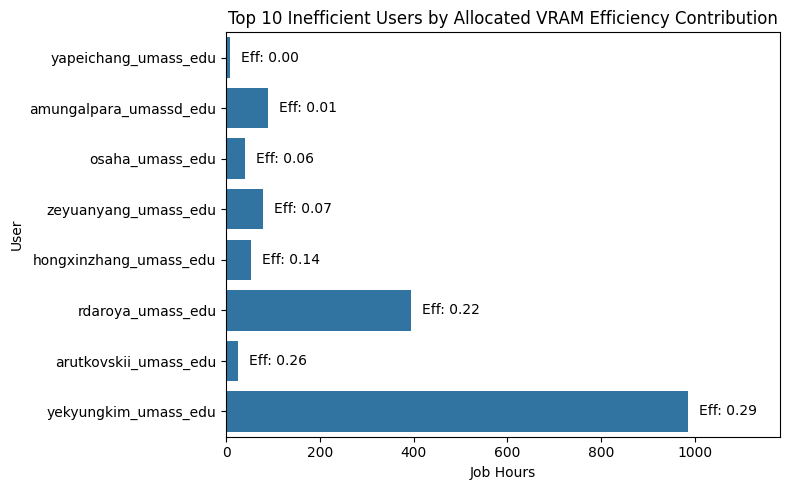

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

inefficient_users = efficiency_analysis.find_inefficient_users_by_alloc_vram_efficiency(
    alloc_vram_efficiency_filter={"max": 0.3, "inclusive": True},  # criteria for identifying inefficient users
    min_jobs=5,  # Minimum number of jobs to consider a user
)

# Display top inefficient users by job count
print("\nTop inefficient users by allocated vram efficiency:")
display(inefficient_users.head(10))



# Plot top inefficient users by GPU hours, with efficiency as labels
top_users = inefficient_users.head(10)

plt.figure(figsize=(8, 5))
barplot = sns.barplot(
    y=top_users["User"],
    x=top_users["user_job_hours"],
    orient="h"
)
plt.xlabel("Job Hours")
plt.ylabel("User")
plt.title("Top 10 Inefficient Users by Allocated VRAM Efficiency Contribution")

# Annotate bars with expected_value_alloc_vram_efficiency, keeping text fully inside the plot's right spine
ax = barplot
xmax = top_users["user_job_hours"].max()
# Add headroom for annotation space (20% extra)
xlim = xmax * 1.20 if xmax > 0 else 1
ax.set_xlim(0, xlim)

# Calculate annotation x-position: place at 98% of xlim or just left of the right spine, whichever is smaller
for i, (job_hours, efficiency) in enumerate(
    zip(
        top_users["user_job_hours"],
        top_users["expected_value_alloc_vram_efficiency"],
        strict=True,
    )
):
    # Place annotation at min(job_hours + 2% of xlim, 98% of xlim)
    xpos = min(job_hours + xlim * 0.02, xlim * 0.98)
    # If bar is very close to right spine, nudge annotation left to avoid overlap
    if xpos > xlim * 0.96:
        xpos = xlim * 0.96
    ax.text(
        xpos,
        i,
        f"Eff: {efficiency:.2f}",
        va="center",
        ha="left",
        fontsize=10,
        color="black",
        clip_on=True
    )

plt.tight_layout()
plt.show()

#### <a id='toc1_2_1_2_'></a>[Find Inefficient Users based on vram_hours](#toc0_)


Top inefficient users by VRAM-hours:


,User,job_count,user_job_hours,pi_account,expected_value_alloc_vram_efficiency,expected_value_gpu_count,vram_hours
54,yekyungkim_umass_edu,120,984.928889,pi_miyyer_umass_edu,0.292270,3.625076,285635.377778
36,rdaroya_umass_edu,94,394.503889,pi_smaji_umass_edu,0.222972,1.000000,31560.311111
53,ychittepu_umass_edu,30,130.057222,pi_sniekum_umass_edu,0.311332,2.590274,26950.711111
5,amungalpara_umassd_edu,7,88.045556,pi_mshao_umassd_edu,0.012584,3.363259,23689.600000
57,zeyuanyang_umass_edu,6,78.191389,pi_chuangg_umass_edu,0.071337,3.604805,22229.177778
28,mkarpinska_umass_edu,33,121.656944,pi_miyyer_umass_edu,0.620839,1.594532,15518.866667
24,limr_iastate_edu,48,193.159722,pi_zhuzhang_uri_edu,0.496329,1.000000,15332.722222
21,jrussell_umass_edu,28,58.711389,pi_miyyer_umass_edu,0.830694,1.256793,5903.044444
1,aatmakuru_umass_edu,5,49.721667,pi_hzamani_umass_edu,0.301510,2.000000,5706.000000
17,hongxinzhang_umass_edu,10,52.235833,pi_chuangg_umass_edu,0.144708,1.000000,3378.366667


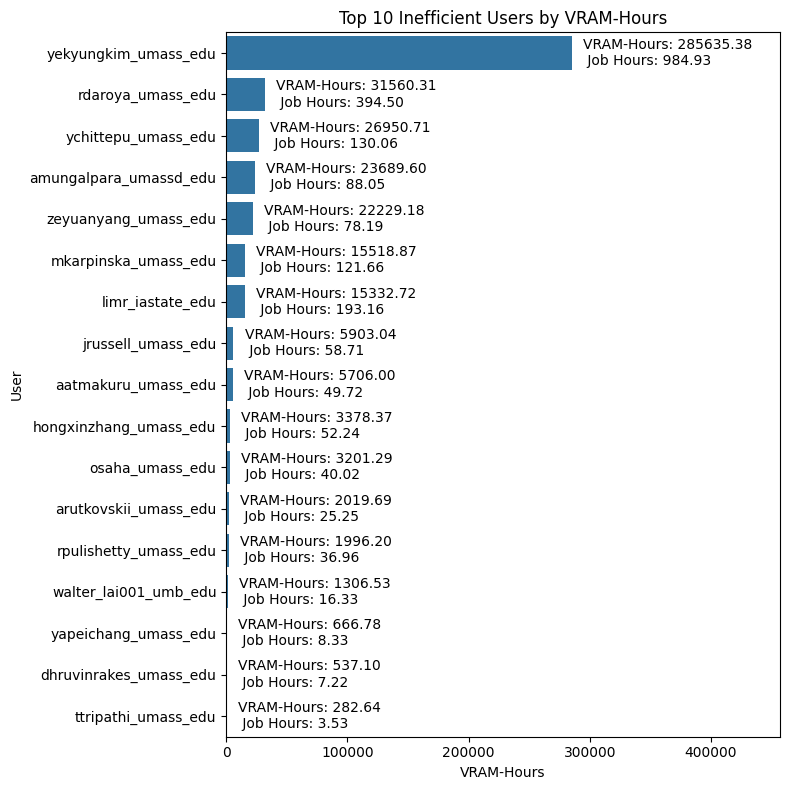

In [24]:
inefficient_users_vram_hours = efficiency_analysis.find_inefficient_users_by_vram_hours(
    vram_hours_filter={"min": 200, "inclusive": True},  # VRAM-hours threshold for identifying inefficient users
    min_jobs=5,  # Minimum number of jobs to consider a user
)
# Display top inefficient users by VRAM-hours
print("\nTop inefficient users by VRAM-hours:")
display(inefficient_users_vram_hours.head(20))

top_users = inefficient_users_vram_hours.head(20)

# Plot top inefficient users by VRAM-hours, with VRAM-hours as labels
plt.figure(figsize=(8, 8))
barplot = sns.barplot(
    y=top_users["User"],
    x=top_users["vram_hours"],
    orient="h"
)
plt.xlabel("VRAM-Hours")
plt.ylabel("User")
plt.title("Top 10 Inefficient Users by VRAM-Hours")
# Annotate bars with gpu_hours, keeping text fully inside the plot's right spine
ax = barplot
xmax = top_users["vram_hours"].max()
# Add headroom for annotation space (20% extra)
xlim = xmax * 1.6 if xmax > 0 else 1
ax.set_xlim(0, xlim)
# Calculate annotation x-position: place at 98% of xlim or just left of the right spine, whichever is smaller
for i, (vram_hours, user_job_hours) in enumerate(
    zip(
        top_users["vram_hours"],
        top_users["user_job_hours"],
        strict=True,
    )
):
    # Place annotation at min(vram_hours + 2% of xlim, 98% of xlim)
    xpos = min(vram_hours + xlim * 0.02, xlim * 0.98)
    ax.text(
        xpos,
        i,
        f"VRAM-Hours: {vram_hours:.2f}\n Job Hours: {user_job_hours:.2f}",
        va="center",
        ha="left",
        fontsize=10,
        color="black",
        clip_on=True
    )
plt.tight_layout()
plt.show()

### <a id='toc1_2_2_'></a>[PI group metrics](#toc0_)

In [25]:
pi_accounts_with_metrics

,pi_account,job_count,pi_acc_job_hours,user_count,pi_acc_vram_hours,expected_value_alloc_vram_efficiency,expected_value_gpu_count
0,pi_casey_umass_edu,3,14.565556,1,1165.244444,0.018506,1.000000
1,pi_mserafini_umass_edu,1,8.007222,1,640.577778,0.197876,1.000000
2,pi_hzamani_umass_edu,6,57.723056,2,6346.111111,0.308526,1.899133
3,pi_mzink_umass_edu,9,45.494444,2,3639.555556,0.201340,1.000000
4,pi_annagreen_umass_edu,5,59.315833,2,14353.622222,0.000132,3.103891
5,pi_hongyu_umass_edu,9,58.979722,5,4718.377778,0.275889,1.000000
6,pi_mraessi_umassd_edu,2,2.173889,1,173.911111,0.006522,1.000000
7,pi_ccapano_umassd_edu,1,1.005556,1,80.444444,0.000000,1.000000
8,pi_harishsunak_uri_edu,1,3.502500,1,280.200000,0.000000,1.000000
9,pi_miyyer_umass_edu,189,1203.294167,5,326707.888889,0.304416,3.734687


#### <a id='toc1_2_2_1_'></a>[Find inefficient PIs](#toc0_)


Top inefficient PI Groups by VRAM-hours:


,pi_account,job_count,pi_acc_job_hours,user_count,pi_acc_vram_hours,expected_value_alloc_vram_efficiency,expected_value_gpu_count
9,pi_miyyer_umass_edu,189,1203.294167,5,326707.888889,0.304416,3.734687
15,pi_smaji_umass_edu,95,398.505278,2,31720.366667,0.221847,1.000000
12,pi_sniekum_umass_edu,35,133.590278,2,27233.355556,0.312976,2.573770
10,pi_chuangg_umass_edu,20,145.178056,4,26627.311111,0.081671,3.174560
11,pi_mshao_umassd_edu,11,120.065278,3,26251.177778,0.013389,3.132653
31,pi_zhuzhang_uri_edu,48,193.159722,1,15332.722222,0.496329,1.000000
4,pi_annagreen_umass_edu,5,59.315833,2,14353.622222,0.000132,3.103891
2,pi_hzamani_umass_edu,6,57.723056,2,6346.111111,0.308526,1.899133
5,pi_hongyu_umass_edu,9,58.979722,5,4718.377778,0.275889,1.000000
16,pi_gvanhorn_umass_edu,11,54.719722,3,4377.577778,0.071016,1.000000


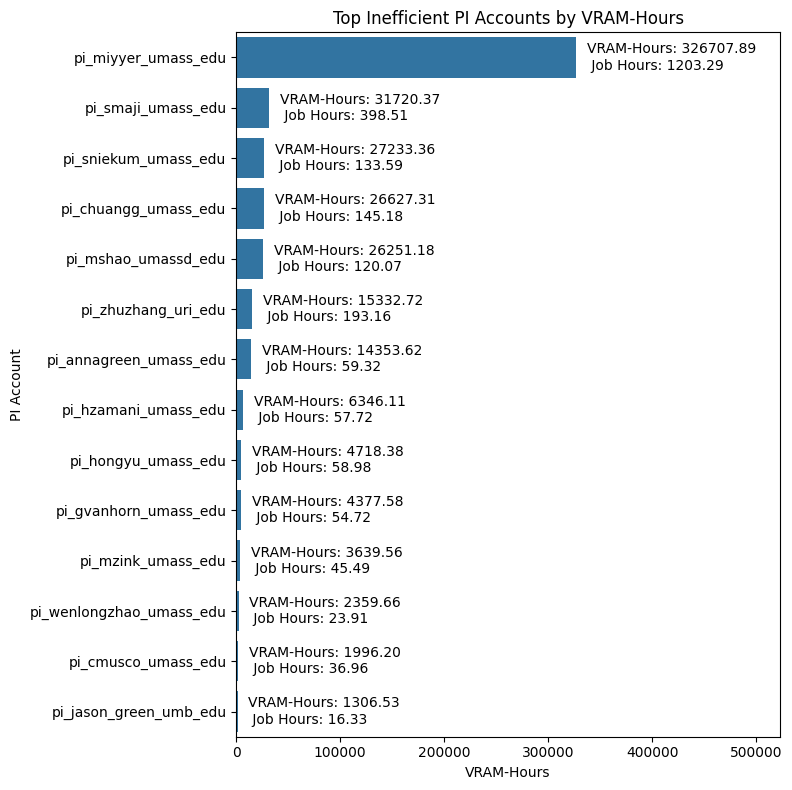

In [26]:
inefficient_pi_vram_hours = efficiency_analysis.find_inefficient_pis_by_vram_hours(
    vram_hours_filter={"min": 200, "inclusive": True},  # VRAM-hours threshold for identifying inefficient users
    min_jobs=5,  # Minimum number of jobs to consider a user
)
# Display top inefficient users by VRAM-hours
print("\nTop inefficient PI Groups by VRAM-hours:")
display(inefficient_pi_vram_hours.head(20))

top_pi_accounts = inefficient_pi_vram_hours.head(20)

# Plot top inefficient users by VRAM-hours, with VRAM-hours as labels
plt.figure(figsize=(8, 8))
barplot = sns.barplot(
    y=top_pi_accounts["pi_account"],
    x=top_pi_accounts["pi_acc_vram_hours"],
    order=top_pi_accounts["pi_account"].tolist(),  # Only show present values
    orient="h"
)
plt.xlabel("VRAM-Hours")
plt.ylabel("PI Account")
plt.title("Top Inefficient PI Accounts by VRAM-Hours")
# Annotate bars with gpu_hours, keeping text fully inside the plot's right spine
ax = barplot
xmax = top_pi_accounts["pi_acc_vram_hours"].max()
# Add headroom for annotation space (20% extra)
xlim = xmax * 1.6 if xmax > 0 else 1
ax.set_xlim(0, xlim)
# Calculate annotation x-position: place at 98% of xlim or just left of the right spine, whichever is smaller
for i, (vram_hours, pi_acc_job_hours) in enumerate(
    zip(
        top_pi_accounts["pi_acc_vram_hours"],
        top_pi_accounts["pi_acc_job_hours"],
        strict=True,
    )
):
    # Place annotation at min(vram_hours + 2% of xlim, 98% of xlim)
    xpos = min(vram_hours + xlim * 0.02, xlim * 0.98)
    ax.text(
        xpos,
        i,
        f"VRAM-Hours: {vram_hours:.2f}\n Job Hours: {pi_acc_job_hours:.2f}",
        va="center",
        ha="left",
        fontsize=10,
        color="black",
        clip_on=True
    )
plt.tight_layout()
plt.show()

## <a id='toc1_3_'></a>[Example: Analyze all jobs with no VRAM constraints](#toc0_)

In [27]:
# Filter jobs where no VRAM constraint was set but a GPU was allocated

filtered_jobs = efficiency_analysis.filter_jobs_for_analysis(
    vram_constraint_filter={"min": 0, "inclusive": False},  # No VRAM constraints
    gpu_count_filter={"min": 1, "inclusive": True}  # At least one GPU allocated
)

jobs_with_metrics = efficiency_analysis.calculate_job_efficiency_metrics(filtered_jobs)

# Set option to display all columns
pd.set_option('display.max_columns', None)
# Display the DataFrame
display(jobs_with_metrics.head(10))
# To revert to default settings (optional)
pd.reset_option('display.max_columns')
print(f"Jobs found: {len(jobs_with_metrics)}")

,JobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,ExitCode,SubmitTime,StartTime,Elapsed,TimeLimit,Partition,NodeList,CPUs,Memory,gpu_count,GPUType,GPUMemUsage,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,allocated_vram,user_jobs,account_jobs,job_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,used_cpu_gib
1,28989215,-1,inference_user_query_review_full.sh,False,non-interactive,pi_rrahimi_umass_edu,changzeng_umass_edu,['gpu:a100'],normal,COMPLETED,SUCCESS,2025-02-16 07:44:48,2025-02-16 07:49:31,3 days 14:28:36,0 days 02:13:00,superpod-a100,[gpu014],8,204800,8,[a100],8.491159e+10,100.0,9.295657e+10,97.740585,0 days 00:04:43,320,640,5,14,691.813333,79.080078,0.123563,0.247125,-1446.586654,86.572556
2,29011960,-1,xphm_ppW.sh,False,non-interactive,pi_mpuerrer_uri_edu,samuel_clyne_uri_edu,['gpu:a100'],normal,COMPLETED,SUCCESS,2025-02-17 17:05:42,2025-02-17 17:06:30,2 days 01:33:17,0 days 02:10:00,uri-gpu,[uri-gpu005],32,204800,1,[a100],2.518260e+10,94.0,8.900047e+09,5.815222,0 days 00:00:48,40,80,2,2,49.554722,23.453125,0.293164,0.586328,-60.804778,8.288815
3,29011961,-1,xphm_pp_NRW.sh,False,non-interactive,pi_mpuerrer_uri_edu,samuel_clyne_uri_edu,['gpu:a100'],normal,COMPLETED,SUCCESS,2025-02-17 17:06:26,2025-02-17 17:40:59,2 days 01:35:28,0 days 02:10:00,uri-gpu,[uri-gpu004],32,204800,1,[a100],2.518260e+10,93.0,8.933704e+09,5.530674,0 days 00:34:33,40,80,2,2,49.591111,23.453125,0.293164,0.586328,-60.849428,8.320160
4,29012688,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q9FH78),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,SUCCESS,2025-02-17 17:55:27,2025-02-19 17:50:51,0 days 00:35:13,0 days 00:08:00,gpu,[uri-gpu001],6,36864,1,[a100],9.185526e+08,100.0,2.081502e+10,15.144115,1 days 23:55:24,23,80,82,82,0.586944,0.855469,0.010693,0.037194,-2.663632,19.385502
5,29014540,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q8H1F0),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,SUCCESS,2025-02-17 19:24:26,2025-02-19 20:12:53,0 days 00:58:59,0 days 00:08:00,gpu,[uri-gpu002],6,36864,1,[a100],1.547698e+09,100.0,2.317913e+10,15.318338,2 days 00:48:27,23,80,82,82,0.983056,1.441406,0.018018,0.06267,-3.948352,21.587246
6,29014545,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q8RXR3),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,SUCCESS,2025-02-17 19:25:27,2025-02-19 20:12:53,0 days 00:38:45,0 days 00:08:00,gpu,[uri-gpu002],6,36864,1,[a100],1.101005e+09,100.0,2.160759e+10,15.018652,2 days 00:47:26,23,80,82,82,0.645833,1.025391,0.012817,0.044582,-2.813865,20.123634
7,29019686,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q1G2Y4),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,SUCCESS,2025-02-17 20:22:56,2025-02-19 20:59:49,0 days 00:29:29,0 days 00:08:00,gpu,[uri-gpu002],6,36864,1,[a100],9.185526e+08,100.0,1.742198e+10,14.302629,2 days 00:36:53,23,80,82,82,0.491389,0.855469,0.010693,0.037194,-2.229988,16.225483
8,29020094,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-F4J3V2),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,SUCCESS,2025-02-17 20:48:26,2025-02-19 21:29:53,0 days 00:35:20,0 days 00:08:00,gpu,[uri-gpu002],6,36864,1,[a100],4.781507e+08,100.0,1.928894e+10,15.287186,2 days 00:41:27,23,80,82,82,0.588889,0.445312,0.005566,0.019361,-3.056926,17.964222
31,29041340,0,kinematic,True,non-interactive,pi_ekalogerakis_umass_edu,pradyumngoya_umass_edu,['vram40'],normal,COMPLETED,SUCCESS,2025-02-18 22:56:42,2025-02-19 14:12:33,0 days 04:50:18,0 days 00:48:00,gpu-preempt,[ece-gpu002],16,153600,2,[a100],2.128819e+10,100.0,1.318011e+11,46.683910,0 days 15:15:51,80,80,1,1,9.676667,19.826172,0.247827,0.247827,-13.499180,122.749352
32,29041359,-1,150,False,non-interactive,pi_smaji_umass_edu,jmhamilton_umass_edu,['vram80'],normal,PREEMPTED,SUCCESS,2025-02-18 23:00:15,202

Jobs found: 387


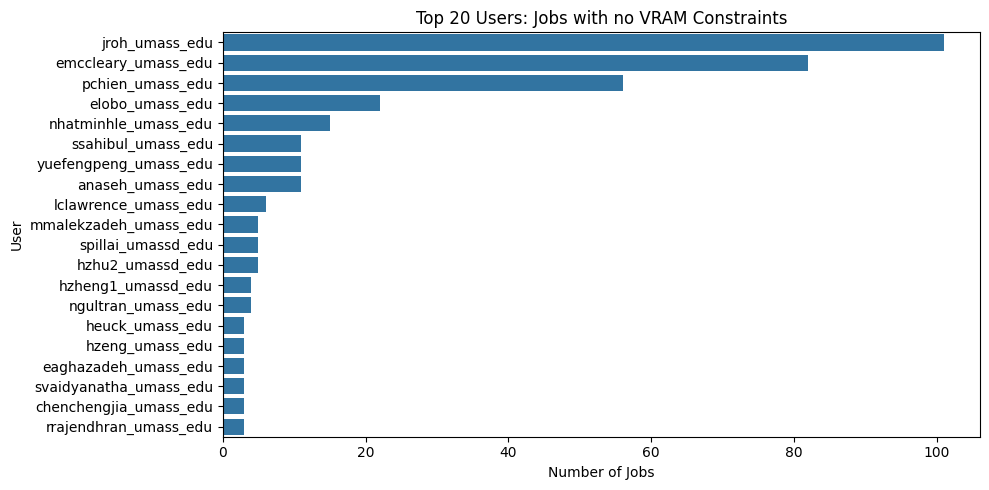

In [28]:
# Plot top users by number of jobs with no VRAM constraints
if not filtered_jobs.empty:
    plt.figure(figsize=(10, 5))
    user_counts = filtered_jobs["User"].value_counts().head(20)
    sns.barplot(x=user_counts.values, y=user_counts.index, orient="h")
    plt.xlabel("Number of Jobs")
    plt.ylabel("User")
    plt.title("Top 20 Users: Jobs with no VRAM Constraints")
    plt.tight_layout()
    plt.show()
else:
    print("No jobs found without VRAM constraints.")

In [29]:
#Aggregate by GPU type 
efficiency_analysis.aggregate_gpu_metrics_by_query(
    query=query)

AttributeError: 'EfficiencyAnalysis' object has no attribute 'calculate_efficiency_metrics'